<a href="https://colab.research.google.com/github/stanislavfort/dissect-git-re-basin/blob/master/git_rebasin_Stan_MLP_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the Git Re-Basin experiments by Stanislav Fort, starting from their codebase (MLP on MNIST)
 
I got excited about the Git Re-Basin paper (https://arxiv.org/abs/2209.04836) yesterday (Sep 14 2022) and since the claims seemed pretty strong I decided to replicate the key results. I started from the codebase the authors put on GitHub (https://github.com/samuela/git-re-basin), and took the relevant bits and pieces, put them into a Colab, and write a one-click-runnable replication.

**tldr: I wasn't able to replicate the key observation that the permutation applied to a network moves it to a linearly connected basin of another** 

I added a lot of analysis on top to make sure I knew what was going on. Some things that seem to be true that I wanted to verify: 

1) the permutation procedure preserves the network exactly as it was in terms of its input-ouput behavior, exactly as it should
2) the (network + permutation)'s weight vector gets non-randomly closer to the network towards which the permutation was developed, as it should

However, the key claim that after the permutation is applied the new network is now **within the same convex, linearly connected basin of the other network, I was not able to replicate**. This is unusual since I literally took bits of code from the author's codebase. If you find a problem with my replication, please let me know on Twitter (@stanislavfort) or via email.

Here's the money plot:
Explanation: I have two networks trained from init (model 1 and model 2), and the permutation from the paper applied to model 2 towards model 1. The model 2 + permutation should be in the same linearly connected basin as model 1, which would suggest a nice linear path of low loss between the aqua triangle and the red circle. However, as you can see, there is a bump! The yellow line isn't a nice connected bridge and  on top of that the loss on the weight space cut defined by the model 1, model 2 and model 2 + permutation shows clearly 3 different basins, not 2, as the key claim would suggest.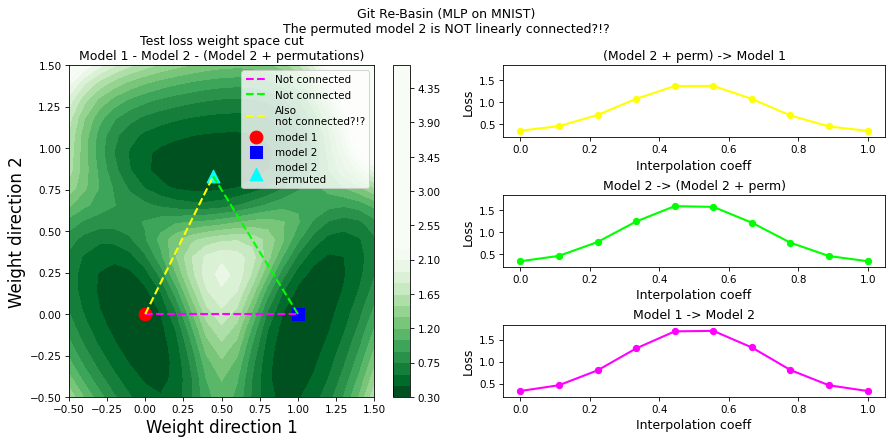

## Library imports

In [1]:
!pip install augmax
# Install the newest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done


## Permutation utils

In [2]:
from collections import defaultdict
from typing import NamedTuple

import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment


class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict

# def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
#   """We assume that one permutation cannot appear in two axes of the same weight array."""
#   assert num_hidden_layers >= 1
#   return PermutationSpec(
#       perm_to_axes={
#           f"P_{i}": [(f"Dense_{i}/kernel", 1), (f"Dense_{i}/bias", 0), (f"Dense_{i+1}/kernel", 0)]
#           for i in range(num_hidden_layers)
#       },
#       axes_to_perm={
#           "Dense_0/kernel": (None, "P_0"),
#           **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
#              for i in range(1, num_hidden_layers)},
#           **{f"Dense_{i}/bias": (f"P_{i}", )
#              for i in range(num_hidden_layers)},
#           f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
#           f"Dense_{num_hidden_layers}/bias": (None, ),
#       })

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "Dense_0/kernel": (None, "P_0"),
      **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
         for i in range(1, num_hidden_layers)},
      **{f"Dense_{i}/bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
      f"Dense_{num_hidden_layers}/bias": (None, ),
  })

def vgg16_permutation_spec() -> PermutationSpec:
  return permutation_spec_from_axes_to_perm({
      "Conv_0/kernel": (None, None, None, "P_Conv_0"),
      **{f"Conv_{i}/kernel": (None, None, f"P_Conv_{i-1}", f"P_Conv_{i}")
         for i in range(1, 13)},
      **{f"Conv_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/scale": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      "Dense_0/kernel": ("P_Conv_12", "P_Dense_0"),
      "Dense_0/bias": ("P_Dense_0", ),
      "Dense_1/kernel": ("P_Dense_0", "P_Dense_1"),
      "Dense_1/bias": ("P_Dense_1", ),
      "Dense_2/kernel": ("P_Dense_1", None),
      "Dense_2/bias": (None, ),
  })

def resnet20_permutation_spec() -> PermutationSpec:
  conv = lambda name, p_in, p_out: {f"{name}/kernel": (None, None, p_in, p_out)}
  norm = lambda name, p: {f"{name}/scale": (p, ), f"{name}/bias": (p, )}
  dense = lambda name, p_in, p_out: {f"{name}/kernel": (p_in, p_out), f"{name}/bias": (p_out, )}

  # This is for easy blocks that use a residual connection, without any change in the number of channels.
  easyblock = lambda name, p: {
      **conv(f"{name}/conv1", p, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p),
      **norm(f"{name}/norm2", p)
  }

  # This is for blocks that use a residual connection, but change the number of channels via a Conv.
  shortcutblock = lambda name, p_in, p_out: {
      **conv(f"{name}/conv1", p_in, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p_out),
      **norm(f"{name}/norm2", p_out),
      **conv(f"{name}/shortcut/layers_0", p_in, p_out),
      **norm(f"{name}/shortcut/layers_1", p_out),
  }

  return permutation_spec_from_axes_to_perm({
      **conv("conv1", None, "P_bg0"),
      **norm("norm1", "P_bg0"),
      #
      **easyblock("blockgroups_0/blocks_0", "P_bg0"),
      **easyblock("blockgroups_0/blocks_1", "P_bg0"),
      **easyblock("blockgroups_0/blocks_2", "P_bg0"),
      #
      **shortcutblock("blockgroups_1/blocks_0", "P_bg0", "P_bg1"),
      **easyblock("blockgroups_1/blocks_1", "P_bg1"),
      **easyblock("blockgroups_1/blocks_2", "P_bg1"),
      #
      **shortcutblock("blockgroups_2/blocks_0", "P_bg1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_2", "P_bg2"),
      #
      **dense("dense", "P_bg2", None),
  })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
      w = jnp.take(w, perm[p], axis=axis)

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(rng, ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]
      A = jnp.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = jnp.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = jnp.moveaxis(w_b, axis, 0).reshape((n, -1))
        A += w_a @ w_b.T

      ri, ci = linear_sum_assignment(A, maximize=True)
      assert (ri == jnp.arange(len(ri))).all()

      oldL = jnp.vdot(A, jnp.eye(n)[perm[p]])
      newL = jnp.vdot(A, jnp.eye(n)[ci, :])
      print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = jnp.array(ci)

    if not progress:
      break

  return perm

def test_weight_matching():
  """If we just have a single hidden layer then it should converge after just one step."""
  ps = mlp_permutation_spec(num_hidden_layers=1)
  rng = random.PRNGKey(123)
  num_hidden = 10
  shapes = {
      "Dense_0/kernel": (2, num_hidden),
      "Dense_0/bias": (num_hidden, ),
      "Dense_1/kernel": (num_hidden, 3),
      "Dense_1/bias": (3, )
  }
  params_a = {k: random.normal(rngmix(rng, f"a-{k}"), shape) for k, shape in shapes.items()}
  params_b = {k: random.normal(rngmix(rng, f"b-{k}"), shape) for k, shape in shapes.items()}
  perm = weight_matching(rng, ps, params_a, params_b)
  print(perm)



## Utils

In [3]:
import operator
import re
import time

import jax.numpy as jnp
from flax import traverse_util
from flax.core import freeze, unfreeze
from jax import random, tree_map
from jax.tree_util import tree_reduce

rngmix = lambda rng, x: random.fold_in(rng, hash(x))

class RngPooper:
  """A stateful wrapper around stateless random.PRNGKey's."""

  def __init__(self, init_rng):
    self.rng = init_rng

  def poop(self):
    self.rng, rng_key = random.split(self.rng)
    return rng_key

def l1prox(x, alpha):
  return jnp.sign(x) * jnp.maximum(0, jnp.abs(x) - alpha)

def flatten_params(params):
  return {"/".join(k): v for k, v in traverse_util.flatten_dict(unfreeze(params)).items()}

def unflatten_params(flat_params):
  return freeze(
      traverse_util.unflatten_dict({tuple(k.split("/")): v
                                    for k, v in flat_params.items()}))

def merge_params(a, b):
  return unflatten_params({**a, **b})

def kmatch(pattern, key):
  regex = "^"
  i = 0
  while i < len(pattern):
    if pattern[i] == "*":
      if i + 1 < len(pattern) and pattern[i + 1] == "*":
        regex += "(.*)"
        i += 2
      else:
        regex += "([^\/]*)"
        i += 1
    else:
      regex += pattern[i]
      i += 1
  regex += "$"
  return re.fullmatch(regex, key)

assert kmatch("*", "a") is not None
assert kmatch("*", "a").group(0) == "a"
assert kmatch("*", "a").group(1) == "a"
assert kmatch("abc", "def") is None
assert kmatch("abc/*/ghi", "abc/def/ghi").group(1) == "def"
assert kmatch("abc/**/jkl", "abc/def/ghi/jkl").group(1) == "def/ghi"
assert kmatch("abc/*/jkl", "abc/def/ghi/jkl") is None
assert kmatch("**/*", "abc/def/ghi/jkl").group(1) == "abc/def/ghi"
assert kmatch("**/*", "abc/def/ghi/jkl").group(2) == "jkl"


## MLP model and dataset

In [4]:

"""Train an MLP on MNIST on one random seed. Serialize the model for
interpolation downstream."""
import argparse

import augmax
import flax
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from flax import linen as nn
from flax.training.train_state import TrainState
from jax import jit, random, tree_map, value_and_grad, vmap
from tqdm import tqdm

# See https://github.com/tensorflow/tensorflow/issues/53831.

# See https://github.com/google/jax/issues/9454.
tf.config.set_visible_devices([], "GPU")

activation = nn.relu

class MLPModel(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = jnp.reshape(x, (-1, 28 * 28))
    x = nn.Dense(512)(x)
    x = activation(x)
    x = nn.Dense(512)(x)
    x = activation(x)
    x = nn.Dense(512)(x)
    x = activation(x)
    x = nn.Dense(10)(x)
    x = nn.log_softmax(x)
    return x

def make_stuff(model):
  normalize_transform = augmax.ByteToFloat()

  @jit
  def batch_eval(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, {"num_correct": num_correct}

  # Stan's addition for saving predictions of the model to see how they differ
  @jit
  def batch_predictions(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, logits, y_onehot, {"num_correct": num_correct}

  @jit
  def step(train_state, images_f32, labels):
    (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_f32, labels)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}

  def dataset_loss_and_accuracy(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, infos = zip(*[
        batch_eval(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
    )

  # Stan's addition for saving predictions of the model to see how they differ
  def dataset_predictions(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, logits, y_onehots, infos = zip(*[
        batch_predictions(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
        logits,
        y_onehots,
    )

  return {
      "normalize_transform": normalize_transform,
      "batch_eval": batch_eval,
      "step": step,
      "dataset_loss_and_accuracy": dataset_loss_and_accuracy,
      "dataset_predictions": dataset_predictions,
  }

def load_datasets():
  """Return the training and test datasets, unbatched."""
  # See https://www.tensorflow.org/datasets/overview#as_batched_tftensor_batch_size-1.
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds



## Runs details

In [5]:
num_epochs = 20
batch_size = 500
seed = 12421
config_optimizer = "sgd" #"adam"
learning_rate = 1e-3

runs_to_collect = 2 #Stan's new stuff

rng = random.PRNGKey(seed)

In [6]:
# storing model params after training
flattened_models_list = []

for run_i in range(runs_to_collect):

  rng = random.PRNGKey(seed+run_i) # chaning the seed each run 
  rngmix = lambda rng, x: random.fold_in(rng, hash(x))

  model = MLPModel()
  stuff = make_stuff(model)

  print("--------------------------")
  print(f"Starting run {run_i}")


  train_ds, test_ds = load_datasets()
  print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
  print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

  num_train_examples = train_ds["images_u8"].shape[0]
  num_test_examples = test_ds["images_u8"].shape[0]
  assert num_train_examples % batch_size == 0
  print("num_train_examples", num_train_examples)
  print("num_test_examples", num_test_examples)

  if config_optimizer == "sgd":
    # See runs:
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/3blb4uhm
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/174j7umt
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/td02y8gg
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=1e-6,
        peak_value=learning_rate,
        warmup_steps=10,
        # Confusingly, `decay_steps` is actually the total number of steps,
        # including the warmup.
        decay_steps=num_epochs * (num_train_examples // batch_size),
    )
    tx = optax.sgd(lr_schedule, momentum=0.9)
  elif config_optimizer == "adam":
    # See runs:
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/1b1gztfx (trim-fire-575)
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/1hrmw7wr (wild-dream-576)
    tx = optax.adam(learning_rate)
  else:
    # See runs:
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/k4luj7er (faithful-spaceship-579)
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/3ru7xy8c (sage-forest-580)
    tx = optax.adamw(learning_rate, weight_decay=1e-4)

  train_state = TrainState.create(
      apply_fn=model.apply,
      params=model.init(rngmix(rng, f"init{run_i}"), jnp.zeros((1, 28, 28, 1)))["params"],
      tx=tx,
  )

  for epoch in tqdm(range(num_epochs)):
    infos = []
  
    batch_ix = random.permutation(rngmix(rng, f"epoch-{epoch}"), num_train_examples).reshape(
        (-1, batch_size))
    for i in range(batch_ix.shape[0]):
      p = batch_ix[i, :]
      images_u8 = train_ds["images_u8"][p, :, :, :]
      labels = train_ds["labels"][p]
      train_state, info = stuff["step"](train_state, images_u8, labels)
    

    train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
    train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples

    
    actest_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                    10_000)

    params_l2 = tree_map(lambda x: jnp.sqrt(jnp.sum(x**2)),
                          flatten_params({"params_l2": train_state.params}))
    
    
  # summary
  print("-----------------")
  print(f"Run {run_i} DONE!")
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                10_000)
  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                60_000)
  print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

  flattened_models_list.append(flatten_params(train_state.params))


--------------------------
Starting run 0
train_ds labels hash 5818746533906924388
test_ds labels hash 3879493666364736891
num_train_examples 60000
num_test_examples 10000


100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.33578237891197205 test accuracy=0.9062000513076782 train loss=0.3515421152114868 train accuracy=0.9010833501815796
--------------------------
Starting run 1
train_ds labels hash 5818746533906924388
test_ds labels hash 3879493666364736891
num_train_examples 60000
num_test_examples 10000


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.3348362147808075 test accuracy=0.9057000279426575 train loss=0.3467029929161072 train accuracy=0.9021666646003723


In [7]:
# flattening params
assert len(flattened_models_list) >= 2
flattened_model1 = flattened_models_list[0]
flattened_model2 = flattened_models_list[1]

## Permuting the model

In [8]:
permutation_spec = mlp_permutation_spec(3)
final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                    flattened_model1, flattened_model2)

0/P_0: 86.71257019042969
0/P_1: 43.93544387817383
0/P_2: 24.090309143066406
1/P_0: 10.849174499511719
1/P_2: 0.0
1/P_1: 1.0033340454101562
2/P_2: 2.9547958374023438
2/P_0: 1.2578201293945312
2/P_1: 0.5078887939453125
3/P_0: 0.745819091796875
3/P_1: 0.0634765625
3/P_2: 1.6500244140625
4/P_0: 0.29327392578125
4/P_1: 0.0273895263671875
4/P_2: 0.08725738525390625
5/P_1: 0.0
5/P_2: 0.0
5/P_0: 0.05960845947265625
6/P_1: 0.0020751953125
6/P_2: 0.3753662109375
6/P_0: 0.1222991943359375
7/P_2: 0.0
7/P_1: 0.078948974609375
7/P_0: 0.1468353271484375
8/P_1: 0.0207977294921875
8/P_0: 0.18207550048828125
8/P_2: 0.59912109375
9/P_0: 0.0
9/P_1: 0.00982666015625
9/P_2: 0.20372772216796875
10/P_2: 0.0
10/P_0: 0.1798248291015625
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0


In [9]:
# applying the permutation to the second model
flattened_model1_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model1)
        )
flattened_model2_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model2)
        )

## Performance verification

### Model 1

In [10]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                  60_000)
print("Model 1")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1
train_loss=0.3515421152114868 train_accuracy=0.9010833501815796
test_loss=0.33578237891197205 test_accuracy=0.9062000513076782


### Model 2

In [11]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                  60_000)
print("Model 2")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2
train_loss=0.3467029929161072 train_accuracy=0.9021666646003723
test_loss=0.3348362147808075 test_accuracy=0.9057000279426575


### Model 1 with permutation

In [12]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), train_ds,
                                                                  60_000)
print("Model 1 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1 with permutation
train_loss=0.3515421152114868 train_accuracy=0.9010833501815796
test_loss=0.33578240871429443 test_accuracy=0.9062000513076782


### Model 2 with permutation

In [13]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                  60_000)
print("Model 2 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2 with permutation
train_loss=0.3467029929161072 train_accuracy=0.9021666646003723
test_loss=0.3348362147808075 test_accuracy=0.9057000279426575


## Weight vector analysis

In [14]:
flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)

In [15]:
# all in long vectors
keys = flattened_model1.keys()

v1 = jnp.concatenate([flattened_model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([flattened_model2[key].reshape([-1]) for key in keys],axis=0)
v1_perm = jnp.concatenate([flattened_model1_permuted_flat[key].reshape([-1]) for key in keys],axis=0)
v2_perm = jnp.concatenate([flattened_model2_permuted_flat[key].reshape([-1]) for key in keys],axis=0)

In [16]:
vectors_to_show = [
    ("model 1", v1),
    ("model 2", v2),
    ("model 1 + perms", v1_perm),
    ("model 2 + perms", v2_perm), 
]

for vector_str, vector in vectors_to_show:
  print(f"{vector_str} length**2={(jnp.sum(vector**2))}")

# the permutation should preserve the length

model 1 length**2=1573.85888671875
model 2 length**2=1578.2943115234375
model 1 + perms length**2=1573.858642578125
model 2 + perms length**2=1578.29443359375


In [17]:
coses_grid = np.zeros((len(vectors_to_show),len(vectors_to_show)))
for i,(vector_str1, vector1) in enumerate(vectors_to_show):
  for j,(vector_str2, vector2) in enumerate(vectors_to_show):
    cos_now = jnp.sum(vector1*vector2)/jnp.sqrt(jnp.sum(vector1**2))/jnp.sqrt(jnp.sum(vector2**2))
    print(f"cos({vector_str1},{vector_str2})={cos_now}")
    coses_grid[i,j] = cos_now

cos(model 1,model 1)=1.0
cos(model 1,model 2)=-0.00044684793101623654
cos(model 1,model 1 + perms)=0.0013348129577934742
cos(model 1,model 2 + perms)=0.11132391542196274
cos(model 2,model 1)=-0.0004468479019124061
cos(model 2,model 2)=1.0
cos(model 2,model 1 + perms)=0.0007925484096631408
cos(model 2,model 2 + perms)=0.002385521773248911
cos(model 1 + perms,model 1)=0.0013348129577934742
cos(model 1 + perms,model 2)=0.0007925483514554799
cos(model 1 + perms,model 1 + perms)=1.0
cos(model 1 + perms,model 2 + perms)=-0.000446847639977932
cos(model 2 + perms,model 1)=0.11132391542196274
cos(model 2 + perms,model 2)=0.002385521773248911
cos(model 2 + perms,model 1 + perms)=-0.000446847639977932
cos(model 2 + perms,model 2 + perms)=1.0000001192092896


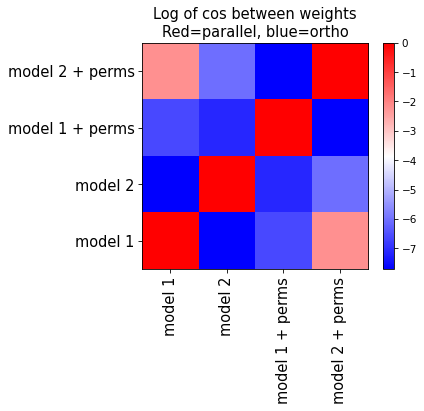

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5,4),dpi=75)
plt.title("Log of cos between weights\nRed=parallel, blue=ortho",fontsize=14)
fig.patch.set_facecolor('white')
plt.imshow(np.log(np.abs(coses_grid)),cmap=plt.cm.bwr,origin="lower")
plt.xticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],rotation = 90,fontsize=14)
plt.yticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],fontsize=14)
plt.colorbar()
plt.show()


## Linear interpolations of weights = test for linear mode connectivity

In [19]:
def get_linear_combination(factor1,vector1,factor2,vector2):
  return dict(
      [(key,factor1*vector1[key]+factor2*vector2[key]) for key in vector1.keys()]
  )

### Model 1 -> Model 2

0 0.0 0.33578238
1 0.1111111111111111 0.46645978
2 0.2222222222222222 0.8032946
3 0.3333333333333333 1.3009666
4 0.4444444444444444 1.686571
5 0.5555555555555556 1.6978253
6 0.6666666666666666 1.3211654
7 0.7777777777777777 0.8098607
8 0.8888888888888888 0.4640089
9 1.0 0.3348362


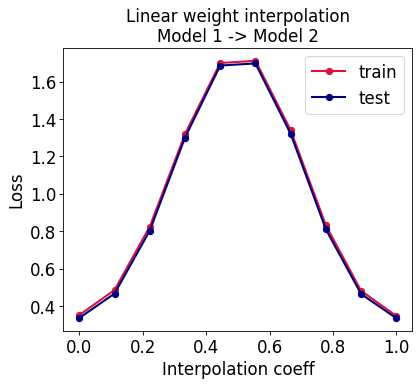

In [20]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2
name = "Model 1 -> Model 2"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

plt.figure(figsize=(6,5),dpi=75)
plt.gca().patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.33578238
1 0.1111111111111111 0.43654788
2 0.2222222222222222 0.68384945
3 0.3333333333333333 1.0499748
4 0.4444444444444444 1.3410358
5 0.5555555555555556 1.3471649
6 0.6666666666666666 1.0507759
7 0.7777777777777777 0.6771305
8 0.8888888888888888 0.43217042
9 1.0 0.3348362


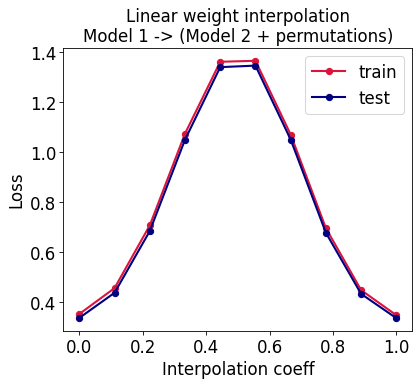

In [41]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2_permuted_flat
name = "Model 1 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 2 + permutations

0 0.0 0.3348362
1 0.1111111111111111 0.45639324
2 0.2222222222222222 0.7703903
3 0.3333333333333333 1.2349957
4 0.4444444444444444 1.5826029
5 0.5555555555555556 1.566269
6 0.6666666666666666 1.2075806
7 0.7777777777777777 0.7542265
8 0.8888888888888888 0.4521969
9 1.0 0.3348362


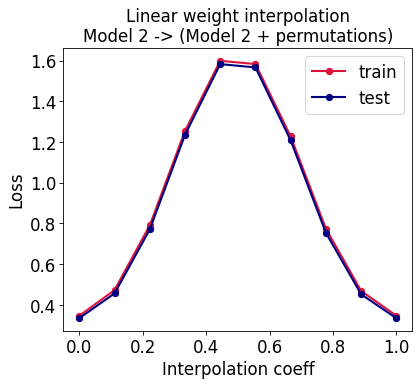

In [42]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model2_permuted_flat
name = "Model 2 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 1 + permutations

0 0.0 0.3348362
1 0.1111111111111111 0.463622
2 0.2222222222222222 0.8105056
3 0.3333333333333333 1.3461521
4 0.4444444444444444 1.768303
5 0.5555555555555556 1.7819927
6 0.6666666666666666 1.3780588
7 0.7777777777777777 0.83690923
8 0.8888888888888888 0.47199583
9 1.0 0.3357824


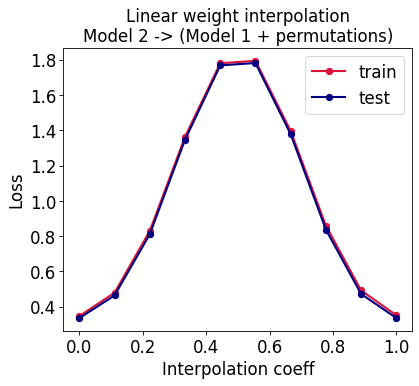

In [43]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model1_permuted_flat
name = "Model 2 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.33578238
1 0.1111111111111111 0.46410424
2 0.2222222222222222 0.799314
3 0.3333333333333333 1.2984328
4 0.4444444444444444 1.6747987
5 0.5555555555555556 1.671661
6 0.6666666666666666 1.2952017
7 0.7777777777777777 0.8028864
8 0.8888888888888888 0.46624193
9 1.0 0.3357824


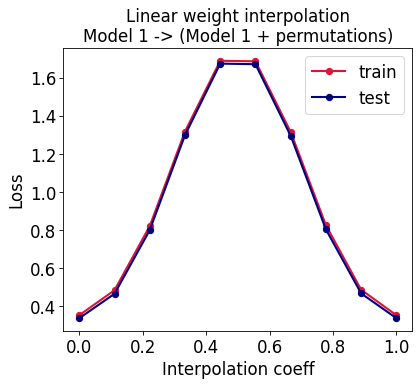

In [44]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model1_permuted_flat
name = "Model 1 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Predictions

In [25]:
def compare_predictions(
    model1,
    model2,
):

  _, _, logits1, _ = stuff["dataset_predictions"](model1, test_ds,
                                                                    10_000)
  _, _, logits2, _ = stuff["dataset_predictions"](model2, test_ds,
                                                                    10_000)
  
  return jnp.sum(jnp.argmax(logits1[0],axis=-1) != jnp.argmax(logits2[0],axis=-1))
  


In [26]:
models_to_show = [
    ("model 1", flattened_model1),
    ("model 2", flattened_model2),
    ("model 1 + perms", flattened_model1_permuted_flat),
    ("model 2 + perms", flattened_model2_permuted_flat), 
]

disagreement_grid = np.zeros((len(models_to_show),len(models_to_show)))
for i,(vector_str1, vector1) in enumerate(models_to_show):
  for j,(vector_str2, vector2) in enumerate(models_to_show):
    disagreement_now = compare_predictions(
        unflatten_params(vector1),
        unflatten_params(vector2)
        )
    print(f"Disagreemnt {vector_str1} vs {vector_str2}={disagreement_now}")
    disagreement_grid[i,j] = disagreement_now

Disagreemnt model 1 vs model 1=0
Disagreemnt model 1 vs model 2=312
Disagreemnt model 1 vs model 1 + perms=0
Disagreemnt model 1 vs model 2 + perms=312
Disagreemnt model 2 vs model 1=312
Disagreemnt model 2 vs model 2=0
Disagreemnt model 2 vs model 1 + perms=312
Disagreemnt model 2 vs model 2 + perms=0
Disagreemnt model 1 + perms vs model 1=0
Disagreemnt model 1 + perms vs model 2=312
Disagreemnt model 1 + perms vs model 1 + perms=0
Disagreemnt model 1 + perms vs model 2 + perms=312
Disagreemnt model 2 + perms vs model 1=312
Disagreemnt model 2 + perms vs model 2=0
Disagreemnt model 2 + perms vs model 1 + perms=312
Disagreemnt model 2 + perms vs model 2 + perms=0


## Loss landscape cuts

In [27]:
# reconstructing parameter dictionaries from flat vectors
def reconstruct(vector, example_flat_model, keys):
  i = 0
  output = dict()
  for key in keys:
    shape_now = example_flat_model[key].shape
    size_now = np.prod(shape_now)
    data_now = vector[i:i+size_now].reshape(shape_now)
    output[key] = data_now
    i = i + size_now
  return output



In [28]:
# testing it, should get all 0.0
rec = reconstruct(v1, flattened_model1, flattened_model1.keys())
for key in rec.keys():
  print(jnp.max(jnp.abs(flattened_model1[key] - rec[key])))
  assert jnp.max(jnp.abs(flattened_model1[key] - rec[key])) == 0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


### Cut model1 - model2 - (model2+perm)

In [29]:
model1 = flattened_model1
model2 = flattened_model2
model3 = flattened_model2_permuted_flat
cut_str = "Model 1 - Model 2 - (Model 2 + permutations)"

keys = model1.keys()

v1 = jnp.concatenate([model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([model2[key].reshape([-1]) for key in keys],axis=0)
v3 = jnp.concatenate([model3[key].reshape([-1]) for key in keys],axis=0)

basis1 = v2-v1
basis1_normed = basis1 / jnp.sqrt(jnp.sum(basis1**2.0))
basis2 = v3 - v1
basis2 = basis2 - jnp.sum(basis2*basis1_normed)*basis1_normed #orthogonalization
basis2_normed = basis2 / jnp.sqrt(jnp.sum(basis2**2.0))

scale = jnp.sqrt(jnp.sum(basis1**2))

t1s = np.linspace(-0.5,1.5,21)
t2s = np.linspace(-0.5,1.5,20)

acc_grid = np.zeros((len(t1s),len(t2s)))
loss_grid = np.zeros((len(t1s),len(t2s)))
logits_grid = np.zeros((len(t1s),len(t2s), 10000, 10))

for i1,t1 in enumerate(t1s):
  print(f"{i1}/{len(t1s)}")
  for i2,t2 in enumerate(t2s):

    new_flat_v = v1 + basis1_normed*t1*scale + basis2_normed*t2*scale
    reconstructed_flat = reconstruct(new_flat_v, model1, keys)
    actest_loss, test_accuracy, logits, onehots = stuff["dataset_predictions"](unflatten_params(reconstructed_flat), test_ds,
                                                                  10_000)
    logits_grid[i1,i2] = np.array(logits[0])
    
    acc_grid[i1,i2] = test_accuracy
    loss_grid[i1,i2] = actest_loss
  
def projection(vector):
  x = jnp.sum((vector - v1)*basis1_normed)/scale
  y = jnp.sum((vector - v1)*basis2_normed)/scale
  return x,y



0/21
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21


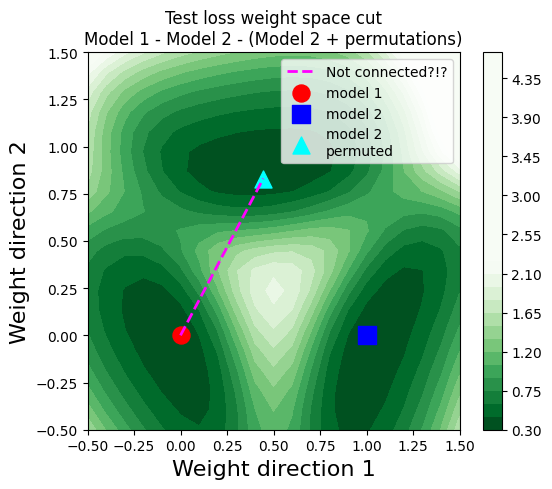

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6,5),dpi=100)
fig.patch.set_facecolor('white')
plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=2.2,levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="fuchsia",label="Not connected?!?")

plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)


plt.legend(fontsize=10,ncol=1)

plt.show()

## Combined plot

In [31]:
def get_linear_cut(start_vector, stop_vector, steps=10):

  ts = np.linspace(0.0,1.0,steps)

  test_losses_list = []
  test_accs_list = []
  train_losses_list = []
  train_accs_list = []

  for i,t in enumerate(ts):
    new_params = get_linear_combination(
        (1.0-t), start_vector, t, stop_vector
    )
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                    10_000)
    test_losses_list.append(test_loss)
    test_accs_list.append(test_accuracy)

    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                    60_000)
    train_losses_list.append(train_loss)
    train_accs_list.append(train_accuracy)

  return ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list


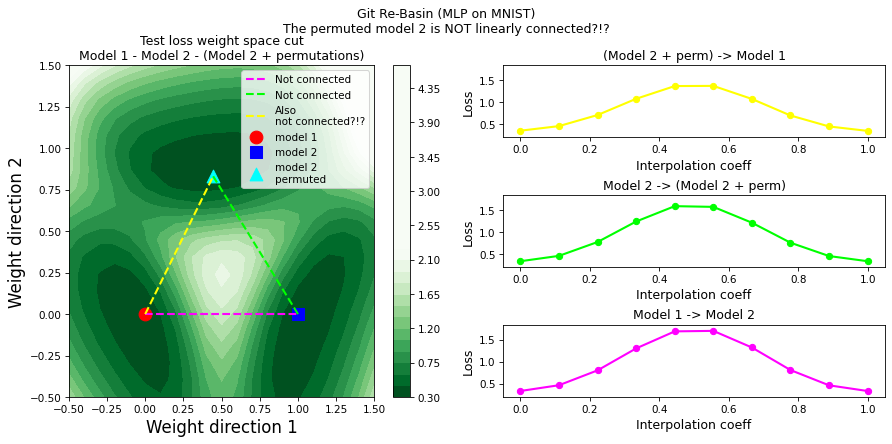

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi = 75)
fig.patch.set_facecolor('white')

plt.suptitle("Git Re-Basin (MLP on MNIST)\nThe permuted model 2 is NOT linearly connected?!?")

plt.subplot(1,2,1)

plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=2.2,levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2],[y1,y2],linewidth=2,linestyle="--",color="fuchsia",label="Not connected")
plt.plot([x2,x2p],[y2,y2p],linewidth=2,linestyle="--",color="lime",label="Not connected")
plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="yellow",label="Also\nnot connected?!?")


plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)

plt.legend(fontsize=10,ncol=1)

# getting the data
all_test_losses = []
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
all_test_losses += test_losses_list

lower_lim = np.min(test_losses_list)-(np.max(test_losses_list)-np.min(test_losses_list))*0.1
upper_lim = np.max(test_losses_list)+(np.max(test_losses_list)-np.min(test_losses_list))*0.1


plt.subplot(3,2,2)

ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)

plt.title(f"(Model 2 + perm) -> Model 1",fontsize=12)
plt.plot(ts,train_losses_list,label="train",marker="o",color="yellow",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])


plt.subplot(3,2,4)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
plt.title(f"Model 2 -> (Model 2 + perm)",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="lime",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])

plt.subplot(3,2,6)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
plt.title(f"Model 1 -> Model 2",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="fuchsia",linewidth=2)
plt.ylim([np.min(test_losses_list),np.max(test_losses_list)])
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)

plt.ylim([lower_lim, upper_lim])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()